In [1]:
import sys
sys.path.append('..')

from helper_fun import *
import helper_fun

# Silence some expected warnings
filterwarnings("ignore")

from Split_functions_regression.split_furthest_cluster import *
from Split_functions_regression.split_hierarchical_cluster import *
from Split_functions_regression.split_random import *
from Split_functions_regression.split_strat_pIC50 import *
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

SEED = 42
seed_everything(SEED)

compounds = pd.read_csv('../COVID_MOONSHOT/compounds_filtered.csv')
compounds.head(2)

2024-07-25 16:40:54.019782: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,Unnamed: 0,SMILES,CID,f_avg_IC50,r_avg_IC50,ROMol,molecular_weight,n_hba,n_hbd,logp,Ro5_fulfilled,f_avg_pIC50,r_avg_pIC50
0,35,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,DAR-DIA-23aa0b97-19,26.719515,14.641091,<rdkit.Chem.rdchem.Mol object at 0x7fc319ac34c0>,287.105862,3,1,3.28768,True,4.573171,4.834427
1,36,O=C(Cc1cncc2ccccc12)Nc1ccccc1,DAR-DIA-23aa0b97-20,57.590417,45.077469,<rdkit.Chem.rdchem.Mol object at 0x7fc319ac3530>,262.110613,2,1,3.41600,True,4.239650,4.346040


# Random Split

In [2]:
compounds["morgan"] = compounds["SMILES"].apply(smiles_to_fp)
train_x_rand, test_x_rand, train_y_rand, test_y_rand = random_split(compounds["morgan"], compounds["f_avg_pIC50"])
# print(f"Shape of train_x: {train_x.shape}") (476,)
# print(f"Shape of test_x: {test_y.shape}") (119,)

# Define Neural Network Model

In [3]:
def neural_network_model(hidden1, hidden2):
    """
    Creating a neural network from two hidden layers
    using ReLU as activation function in the two hidden layers
    and a linear activation in the output layer.

    Parameters
    ----------
    hidden1 : int
        Number of neurons in first hidden layer.

    hidden2: int
        Number of neurons in second hidden layer.

    Returns
    -------
    model
        Fully connected neural network model with two hidden layers.
    """

    model = Sequential()
    # First hidden layer
    model.add(Dense(hidden1, activation="relu", name="layer1"))
    # Second hidden layer
    model.add(Dense(hidden2, activation="relu", name="layer2"))
    # Output layer
    model.add(Dense(1, activation="linear", name="layer3"))

    # Compile model
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
    return model

In [4]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

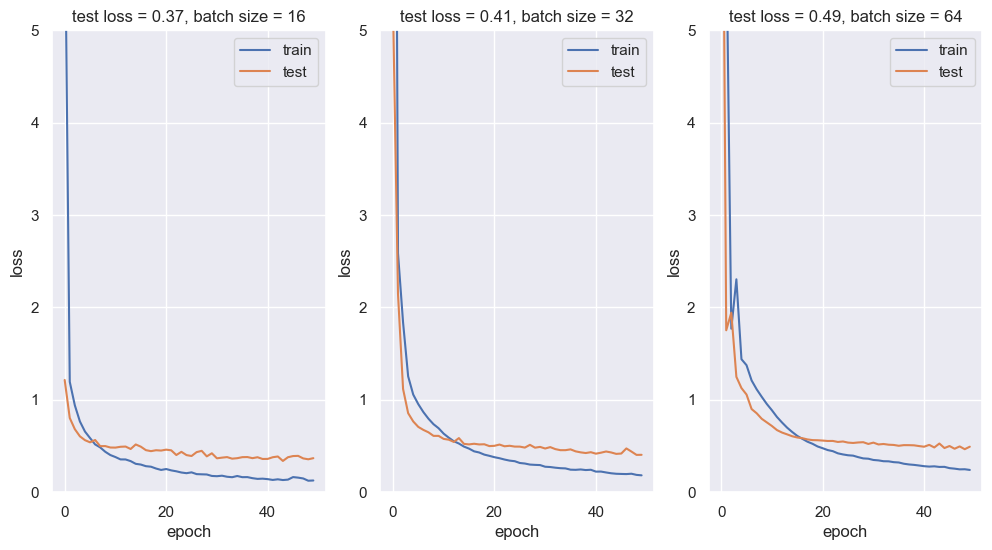

In [10]:
# Plot Random
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list((train_x_rand))).astype(float), train_y_rand.values, batch_size=batch, validation_data=(np.array(list((test_x_rand))).astype(float), test_y_rand.values), verbose=0,epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 5))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch}"
    )
plt.show()